In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, mutual_info_classif
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"

In [2]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()
    
def features_correlation_mutual_info(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals = mutual_info_classif(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [3]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))

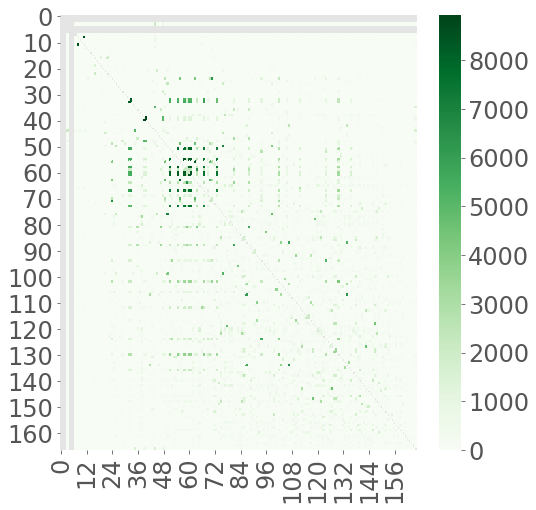

In [4]:
features_correlation(features_shared)

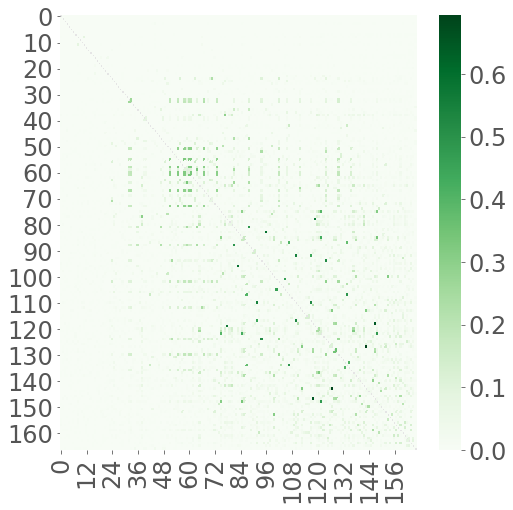

In [5]:
features_correlation_mutual_info(features_shared)

In [6]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
# sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
# features_shared = sel.fit_transform(features_shared)
# features_only_2c9 = sel.transform(features_only_2c9)
# features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold * (1 - threshold))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

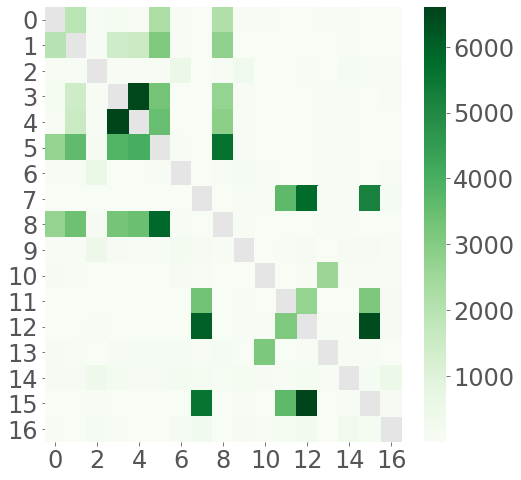

In [7]:
features_correlation(shared_reduced)

We will use the same train/test split with all tests

In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)

We try selecting the top features, moving the percentile value

In [9]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 9 features
NER: 0.623, Sensitivity or recall: 0.322, Specificity: 0.924, Precision: 0.668, Correctly calssified: 0.731, MCC: 0.318
Testing
NER: 0.573, Sensitivity or recall: 0.251, Specificity: 0.895, Precision: 0.576, Correctly calssified: 0.663, MCC: 0.193
Validation set with 10 percentile, 17 features
NER: 0.665, Sensitivity or recall: 0.474, Specificity: 0.855, Precision: 0.608, Correctly calssified: 0.733, MCC: 0.355
Testing
NER: 0.632, Sensitivity or recall: 0.447, Specificity: 0.817, Precision: 0.580, Correctly calssified: 0.683, MCC: 0.283
Validation set with 15 percentile, 25 features
NER: 0.623, Sensitivity or recall: 0.304, Specificity: 0.941, Precision: 0.710, Correctly calssified: 0.736, MCC: 0.332
Testing
NER: 0.580, Sensitivity or recall: 0.233, Specificity: 0.928, Precision: 0.646, Correctly calssified: 0.677, MCC: 0.230
Validation set with 20 percentile, 34 features
NER: 0.719, Sensitivity or recall: 0.577, Specificity: 0.861, Precisio

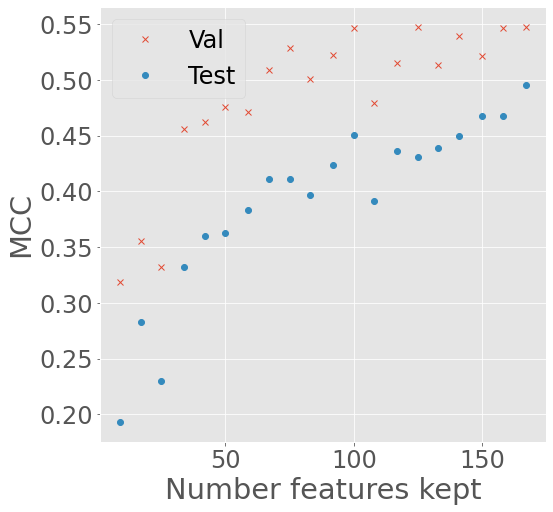

In [10]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
NER: 0.611, Sensitivity or recall: 0.312, Specificity: 0.911, Precision: 0.623, Correctly calssified: 0.718, MCC: 0.282
Testing
NER: 0.588, Sensitivity or recall: 0.276, Specificity: 0.901, Precision: 0.611, Correctly calssified: 0.675, MCC: 0.230
Validation set with 10 percentile, 17 features
NER: 0.672, Sensitivity or recall: 0.489, Specificity: 0.855, Precision: 0.615, Correctly calssified: 0.737, MCC: 0.368
Testing
NER: 0.633, Sensitivity or recall: 0.451, Specificity: 0.815, Precision: 0.579, Correctly calssified: 0.683, MCC: 0.284
Validation set with 15 percentile, 25 features
NER: 0.685, Sensitivity or recall: 0.499, Specificity: 0.871, Precision: 0.647, Correctly calssified: 0.752, MCC: 0.401
Testing
NER: 0.637, Sensitivity or recall: 0.433, Specificity: 0.841, Precision: 0.606, Correctly calssified: 0.694, MCC: 0.301
Validation set with 20 percentile, 34 features
NER: 0.726, Sensitivity or recall: 0.594, Specificity: 0.857, Precisio

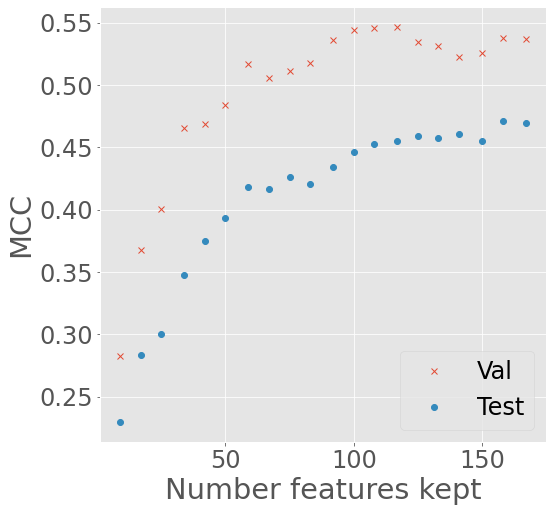

In [11]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
Testing
Validation set with 10 percentile, 17 features
Testing
Validation set with 15 percentile, 25 features
Testing
Validation set with 20 percentile, 34 features
Testing
Validation set with 25 percentile, 42 features
Testing
Validation set with 30 percentile, 50 features
Testing
Validation set with 35 percentile, 59 features
Testing
Validation set with 40 percentile, 67 features
Testing
Validation set with 45 percentile, 75 features
Testing
Validation set with 50 percentile, 83 features
Testing
Validation set with 55 percentile, 92 features
Testing
Validation set with 60 percentile, 100 features
Testing
Validation set with 65 percentile, 108 features
Testing
Validation set with 70 percentile, 117 features
Testing
Validation set with 75 percentile, 125 features
Testing
Validation set with 80 percentile, 133 features
Testing
Validation set with 85 percentile, 141 features
Testing
Validation set with 90 percentile, 150 features
Testing
Valid

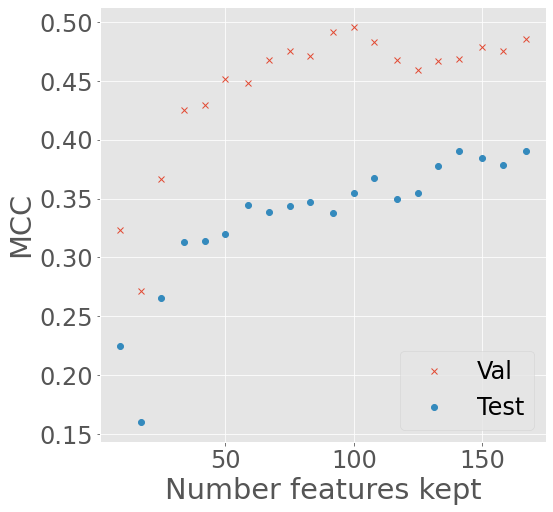

In [12]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
Testing
Validation set with 10 percentile, 17 features
Testing
Validation set with 15 percentile, 25 features
Testing
Validation set with 20 percentile, 34 features
Testing
Validation set with 25 percentile, 42 features
Testing
Validation set with 30 percentile, 50 features
Testing
Validation set with 35 percentile, 59 features
Testing
Validation set with 40 percentile, 67 features
Testing
Validation set with 45 percentile, 75 features
Testing
Validation set with 50 percentile, 83 features
Testing
Validation set with 55 percentile, 92 features
Testing
Validation set with 60 percentile, 100 features
Testing
Validation set with 65 percentile, 108 features
Testing
Validation set with 70 percentile, 117 features
Testing
Validation set with 75 percentile, 125 features
Testing
Validation set with 80 percentile, 133 features
Testing
Validation set with 85 percentile, 141 features
Testing
Validation set with 90 percentile, 150 features
Testing
Valid

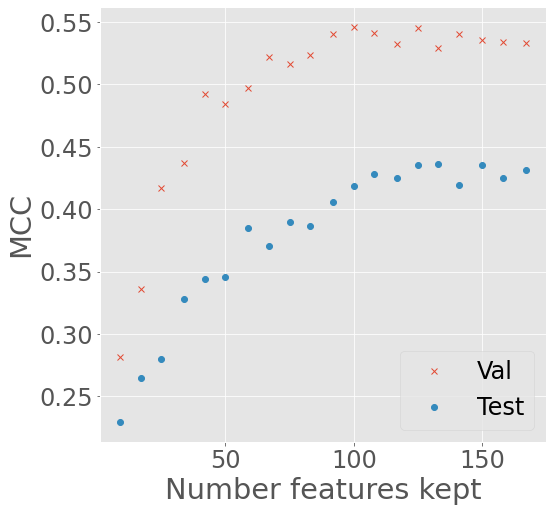

In [13]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [14]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        sel.fit(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced_trans = sel.transform(features_only_2c9)
    train_data_trans = sel.transform(train_data)
    val_data_trans = sel.transform(val_data)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 106 features
NER: 0.759, Sensitivity or recall: 0.684, Specificity: 0.834, Precision: 0.661, Correctly calssified: 0.786, MCC: 0.513
Testing
NER: 0.722, Sensitivity or recall: 0.629, Specificity: 0.816, Precision: 0.659, Correctly calssified: 0.748, MCC: 0.449
Validation set with 0.2 percentile, 82 features
NER: 0.755, Sensitivity or recall: 0.667, Specificity: 0.842, Precision: 0.667, Correctly calssified: 0.786, MCC: 0.509
Testing
NER: 0.711, Sensitivity or recall: 0.614, Specificity: 0.809, Precision: 0.645, Correctly calssified: 0.738, MCC: 0.427
Validation set with 0.30000000000000004 percentile, 57 features
NER: 0.740, Sensitivity or recall: 0.645, Specificity: 0.835, Precision: 0.650, Correctly calssified: 0.774, MCC: 0.481
Testing
NER: 0.690, Sensitivity or recall: 0.561, Specificity: 0.820, Precision: 0.638, Correctly calssified: 0.726, MCC: 0.393
Validation set with 0.4 percentile, 36 features
NER: 0.670, Sensitivity or recall: 0.477, Speci

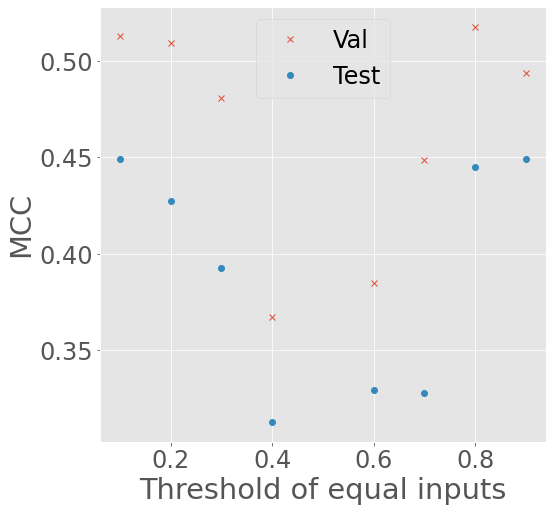

In [15]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [16]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    sel.fit(train_data_trans)
    
    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 9 features
NER: 0.625, Sensitivity or recall: 0.329, Specificity: 0.922, Precision: 0.666, Correctly calssified: 0.731, MCC: 0.320
Testing
NER: 0.573, Sensitivity or recall: 0.255, Specificity: 0.890, Precision: 0.568, Correctly calssified: 0.661, MCC: 0.189
Validation set with 10 percentile, 17 features
NER: 0.673, Sensitivity or recall: 0.506, Specificity: 0.840, Precision: 0.599, Correctly calssified: 0.732, MCC: 0.363
Testing
NER: 0.642, Sensitivity or recall: 0.482, Specificity: 0.801, Precision: 0.579, Correctly calssified: 0.686, MCC: 0.297
Validation set with 15 percentile, 25 features
NER: 0.672, Sensitivity or recall: 0.443, Specificity: 0.901, Precision: 0.680, Correctly calssified: 0.754, MCC: 0.395
Testing
NER: 0.616, Sensitivity or recall: 0.371, Specificity: 0.861, Precision: 0.602, Correctly calssified: 0.684, MCC: 0.268
Validation set with 20 percentile, 31 features
NER: 0.717, Sensitivity or recall: 0.592, Specificity: 0.843, Precisio

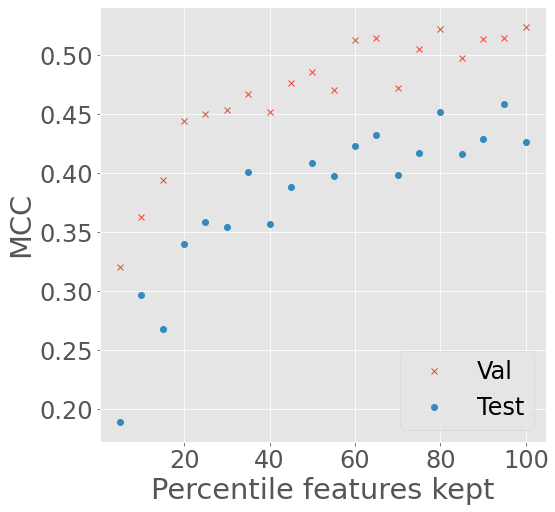

In [17]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 9 features
NER: 0.611, Sensitivity or recall: 0.312, Specificity: 0.911, Precision: 0.623, Correctly calssified: 0.718, MCC: 0.282
Testing
NER: 0.588, Sensitivity or recall: 0.276, Specificity: 0.901, Precision: 0.611, Correctly calssified: 0.675, MCC: 0.230
Validation set with 10 percentile, 17 features
NER: 0.672, Sensitivity or recall: 0.489, Specificity: 0.855, Precision: 0.615, Correctly calssified: 0.737, MCC: 0.368
Testing
NER: 0.633, Sensitivity or recall: 0.451, Specificity: 0.815, Precision: 0.579, Correctly calssified: 0.683, MCC: 0.284
Validation set with 15 percentile, 25 features
NER: 0.685, Sensitivity or recall: 0.499, Specificity: 0.871, Precision: 0.647, Correctly calssified: 0.752, MCC: 0.401
Testing
NER: 0.637, Sensitivity or recall: 0.433, Specificity: 0.841, Precision: 0.606, Correctly calssified: 0.694, MCC: 0.301
Validation set with 20 percentile, 31 features
NER: 0.719, Sensitivity or recall: 0.588, Specificity: 0.851, Precisio

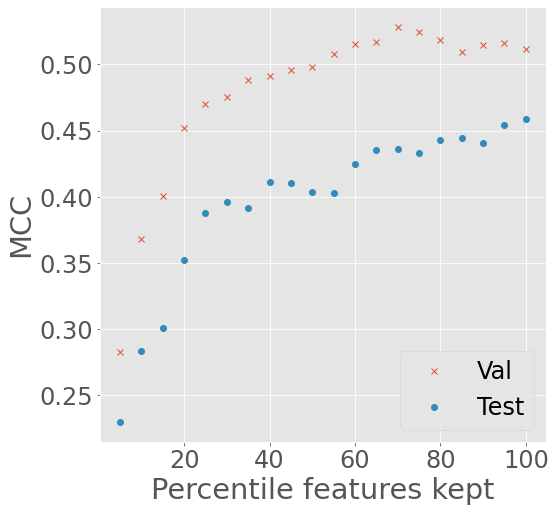

In [18]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    sel.fit(train_data_trans)

    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [19]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 167) (2813, 167) (2994, 167)
(9420, 17) (2813, 17) (2994, 17)
(9420, 17) (2813, 17) (2994, 17)


In [20]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [21]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 3s 14ms/step - loss: 0.8038 - binary_accuracy: 0.7323
Epoch 2/10
221/221 [==============================] - 3s 15ms/step - loss: 0.5532 - binary_accuracy: 0.7834
Epoch 3/10
221/221 [==============================] - 3s 14ms/step - loss: 0.4829 - binary_accuracy: 0.8034
Epoch 4/10
221/221 [==============================] - 3s 13ms/step - loss: 0.4513 - binary_accuracy: 0.8092
Epoch 5/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4329 - binary_accuracy: 0.8181
Epoch 6/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4145 - binary_accuracy: 0.8286
Epoch 7/10
221/221 [==============================] - 4s 16ms/step - loss: 0.3934 - binary_accuracy: 0.8388
Epoch 8/10
221/221 [==============================] - 3s 15ms/step - loss: 0.3768 - binary_accuracy: 0.8447
Epoch 9/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3634 - binary_accuracy: 0.8563
Epoch 10/10
221/221 [=======

Try the same NN with another feature selection method

In [22]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [23]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 3s 15ms/step - loss: 0.6315 - binary_accuracy: 0.6955
Epoch 2/10
221/221 [==============================] - 3s 15ms/step - loss: 0.5606 - binary_accuracy: 0.7066
Epoch 3/10
221/221 [==============================] - 4s 16ms/step - loss: 0.5464 - binary_accuracy: 0.7130
Epoch 4/10
221/221 [==============================] - 3s 13ms/step - loss: 0.5415 - binary_accuracy: 0.7101
Epoch 5/10
221/221 [==============================] - 3s 14ms/step - loss: 0.5385 - binary_accuracy: 0.7192
Epoch 6/10
221/221 [==============================] - 3s 13ms/step - loss: 0.5365 - binary_accuracy: 0.7209
Epoch 7/10
221/221 [==============================] - 3s 14ms/step - loss: 0.5341 - binary_accuracy: 0.7271
Epoch 8/10
221/221 [==============================] - 3s 13ms/step - loss: 0.5332 - binary_accuracy: 0.7163
Epoch 9/10
221/221 [==============================] - 3s 15ms/step - loss: 0.5284 - binary_accuracy: 0.7216
Epoch 10/10
221/221 [=======

In [24]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [25]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 3s 15ms/step - loss: 0.6185 - binary_accuracy: 0.6822
Epoch 2/10
221/221 [==============================] - 3s 13ms/step - loss: 0.5534 - binary_accuracy: 0.7053
Epoch 3/10
221/221 [==============================] - 2s 9ms/step - loss: 0.5429 - binary_accuracy: 0.7141
Epoch 4/10
221/221 [==============================] - 2s 9ms/step - loss: 0.5396 - binary_accuracy: 0.7196
Epoch 5/10
221/221 [==============================] - 2s 9ms/step - loss: 0.5367 - binary_accuracy: 0.7161
Epoch 6/10
221/221 [==============================] - 2s 8ms/step - loss: 0.5348 - binary_accuracy: 0.7203
Epoch 7/10
221/221 [==============================] - 2s 11ms/step - loss: 0.5309 - binary_accuracy: 0.7224
Epoch 8/10
221/221 [==============================] - 2s 8ms/step - loss: 0.5315 - binary_accuracy: 0.7224
Epoch 9/10
221/221 [==============================] - 2s 9ms/step - loss: 0.5308 - binary_accuracy: 0.7205
Epoch 10/10
221/221 [=============

In [26]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(only_2c9_reduced_comb)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.639, Sensitivity or recall: 0.362, Specificity: 0.916, Precision: 0.672, Correctly calssified: 0.738, MCC: 0.343
  Scores for testing
NER: 0.581, Sensitivity or recall: 0.273, Specificity: 0.889, Precision: 0.581, Correctly calssified: 0.666, MCC: 0.207
Scores using C=0.14384498882876628 for validation
NER: 0.641, Sensitivity or recall: 0.371, Specificity: 0.911, Precision: 0.663, Correctly calssified: 0.737, MCC: 0.342
  Scores for testing
NER: 0.582, Sensitivity or recall: 0.280, Specificity: 0.885, Precision: 0.578, Correctly calssified: 0.666, MCC: 0.208
Scores using C=0.20691380811147897 for validation
NER: 0.651, Sensitivity or recall: 0.392, Specificity: 0.910, Precision: 0.673, Correctly calssified: 0.744, MCC: 0.362
  Scores for testing
NER: 0.588, Sensitivity or recall: 0.295, Specificity: 0.880, Precision: 0.581, Correctly calssified: 0.669, MCC: 0.217
Scores using C=0.29763514416313175 for validation
NER: 0.663, Sensitivity or recall